In [6]:
from dm_control import mjcf,mujoco
import PIL.Image

In [7]:
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

%matplotlib inline

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython import display
import PIL.Image

from tempfile import NamedTemporaryFile
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    video=anim.to_html5_video()

    html = display.HTML(video) 
  
    # draw the animation 
    display.display(html)

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

In [14]:
sort_task=mjcf.RootElement(model='sort_task')
sort_task.compiler.angle="radian"
sort_task.compiler.autolimits="true"

sort_task.visual.headlight.diffuse="0.6 0.6 0.6"
sort_task.visual.headlight.ambient="0.1 0.1 0.1"
sort_task.visual.headlight.specular="0 0 0"
sort_task.visual.__getattr__('global').azimuth="0"
sort_task.visual.__getattr__('global').elevation="-30"
sort_task.visual.__getattr__('global').offwidth="1000"
sort_task.visual.__getattr__('global').offheight="1000"
sort_task.visual.quality.shadowsize="4096"

light_wood_texture=sort_task.asset.add('texture',file='/home/vignesh/robot-collab_vig/rocobench/envs/assets/objects/textures/light-wood.png',type="2d",name='tex-light-wood')
light_wood=sort_task.asset.add('material',name='light-wood',reflectance=0.2,texrepeat="15 15",texture='tex-light-wood',texuniform='true')
chequered = sort_task.asset.add('texture', type='2d', builtin='checker', width=300, height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
groundplane = sort_task.asset.add('material', name='grid', texture=chequered, texrepeat=[2, 2], reflectance=.2)

In [15]:
sort_task.worldbody.add('light',pos="0 0 1.5",dir="0 0 -1",directional="true")
sort_task.worldbody.add('geom',name="floor",pos="0 0 -0.5",size="0 0 0.05", type="plane",material=groundplane)
#panda=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/panda/panda.xml')
#sort_task.worldbody.attach(panda)
table_body=sort_task.worldbody.add('body',name='table',pos='0 0.5 0')
table_body.add('geom',name='table_collision',pos='0 0 0.1',size='1.6 0.4 0.05', type='box', group='3', friction='1 0.5 0.0001',rgba='1 1 1 1')

table_top_body=table_body.add('body',name='table_top',pos='0 0 0.1')
table_top_body.add('geom',name='table_top',size='1.6 0.4 0.05',type='box',conaffinity='0',contype='0', group='1',rgba='1 1 1 1')

robot_body=sort_task.worldbody.add('body', name='robot_body',pos='0.0 -0.05 0.01')
robot1_site=robot_body.add('site',name='robot1',pos='-0.2 -0.05 0.1')
robot2_site=robot_body.add('site',name='robot2',pos='0.2 1.05 0.1',euler='0 0 3.14159')
#robot3_site=sort_task.worldbody.add('site',name='robot3',pos='-0.2 1.05 0.3',euler='0 0 3.14159')
robot1=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/ur5e_robotiq/ur5e_robotiq_full.xml')
robot1.model='ur51'
robot2=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/ur5e_robotiq/ur5e_robotiq_full.xml')
robot2.model='ur52'

#robot3=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/ur5e_robotiq/ur5e_robotiq_full.xml')
#robot3.model='ur5e'

robot1_site.attach(robot1)
robot2_site.attach(robot2)
#robot3_site.attach(robot3)
#table_body.add('geom',name='table_left',pos='-1.63 0 1', size='0.02 1.6 1.5', rgba='1 1 1 0', type='box')
#table_body.add('geom',name='table_right',pos='1.63 0 1', size='0.02 1.6 1.5', rgba='1 1 1 0', type='box')
#table_body.add('geom',name='table_front',pos='0 1.63 1', size='1.7 0.02 1.5', rgba='1 1 1 0', type='box')
#table_body.add('geom',name='table_back',pos='0 -1.63 1', size='1.7 0.02 1.5', rgba='1 1 1 0', type='box')

sort_task.worldbody.add('camera', mode="fixed", name='face_panda1', pos="0.062 -2.806 0.768", xyaxes="1.000 0.009 -0.000 0.001 -0.131 0.991")
sort_task.worldbody.add('camera', mode="fixed", name='face_panda2', pos="0.084 3.711 0.772", xyaxes="-1.000 0.016 0.000 0.002 0.111 0.994")
sort_task.worldbody.add('camera', mode="fixed", name='top_cam', pos="-0.001 0.652 2.057", xyaxes="-1.000 -0.000 -0.000 0.000 -1.000 0.019")
sort_task.worldbody.add('camera', mode="fixed", name='right_cam', pos="1.873 0.605 0.926", xyaxes="0.014 1.000 0.000 -0.242 0.003 0.970")
sort_task.worldbody.add('camera', mode="fixed", name='left_cam', pos="-1.873 0.605 0.926", xyaxes="-0.000 -1.000 0.000 0.177 -0.000 0.984")
sort_task.worldbody.add('camera', name='teaser', pos="2.675 -0.747 1.997", xyaxes="0.496 0.869 -0.000 -0.429 0.245 0.869")
sort_task.worldbody.add('camera', name='video', pos="1.957 -0.281 1.731", xyaxes="0.487 0.874 0.000 -0.500 0.278 0.820")

MJCF Element: <camera name="video" class="/" pos="1.9570000000000001 -0.28100000000000003 1.7310000000000001" xyaxes="0.48699999999999999 0.874 0 -0.5 0.27800000000000002 0.81999999999999995"/>

In [16]:
#bin_body1=table_top_body.add('body',name='bin1',pos='-0.5 0 0.05')
#bin_body1.add('geom',name='bottom1',type='box',size='0.35 0.2 0.02',friction="1 0.005 0.0001",material='light-wood')
# bin_body1.add('geom',name='front1',type='box',pos='0 0.2 0.1',size='0.35 0.02 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body1.add('geom',name='back1',type='box',pos='0 -0.2 0.1',size='0.35 0.02 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body1.add('geom',name='right1',type='box',pos='0.35 0 0.1',size='0.02 0.2 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body1.add('geom',name='left1',type='box',pos='-0.35 0 0.1',size='0.02 0.2 0.06',friction="1 0.005 0.0001",material='light-wood')

#box=sort_task.worldbody.add('body',name='black_box',pos='0 0.5 0.37')
#box.add('joint',type='free',name='box_free')
#box.add('body',name='box_top',pos='0 0 0.03')
#box.add('body',name='box_bottom',pos='0 0 -0.03')
#box.add('site',name='box_top',type='sphere',pos='0 0 0.03')
#box.add('site',name='box_bottom',type='sphere',pos='0 0 -0.03')
#box.add('geom',name='box_collision',type='box',size='0.1 0.1 0.3',rgba='0 0 0 1',group=3)
#box.add('geom',name='box_visual',type='box',size='0.1 0.1 0.3',rgba='.85882352 1 0.2 1',group=0)
#bin_body2=table_top_body.add('body',name='bin2',pos='0.5 0 0.05')
#bin_body2.add('geom',name='bottom2',type='box',size='0.35 0.2 0.02',friction="1 0.005 0.0001",material='light-wood')
# bin_body2.add('geom',name='front2',type='box',pos='0 0.2 0.1',size='0.35 0.02 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body2.add('geom',name='back2',type='box',pos='0 -0.2 0.1',size='0.35 0.02 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body2.add('geom',name='right2',type='box',pos='0.35 0 0.1',size='0.02 0.2 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body2.add('geom',name='left2',type='box',pos='-0.35 0 0.1',size='0.02 0.2 0.06',friction="1 0.005 0.0001",material='light-wood')
#bin_body=sort_task.worldbody.add('body', name="bin", pos="0.45 0.5 0.16")
#bin_inside_body=bin_body.add('body', name="bin_inside", pos="0 0 0")
#bin_inside_body.add('geom', name="bin_inside_bottom", pos="0 0 0", size="0.35 0.2 0.02", type="box", group="3", friction="1 0.005 0.0001", material="light-wood")
#bin_inside_body.add('geom', name="bin_inside_front", pos="0 0.2 0.03", size="0.35 0.01 0.06", type="box", group="3", friction="1 0.005 0.0001", material="light-wood")
#bin_inside_body.add('geom', name="bin_inside_back", pos="0 -0.2 0.03", size="0.35 0.01 0.06", type="box", group="3", friction="1 0.005 0.0001", material="light-wood")
#bin_inside_body.add('geom', name="bin_inside_right", pos="0.38 0 0.03", size="0.01 0.18 0.06", type="box", group="3", friction="1 0.005 0.0001", rgba="1 0 0 0")
#bin_inside_body.add('geom', name="bin_inside_left", pos="-0.38 0 0.03", size="0.01 0.18 0.06", type="box", group="3", friction="1 0.005 0.0001", rgba="1 0 0 0" )

#bin_body.add('geom', name="bin_right", pos="0.35 0 0.03", size="0.01 0.2 0.06", type="box", group="3", friction="1 0.005 0.0001", material="light-wood", margin="0.01")
#bin_body.add('geom', name="bin_left", pos="-0.35 0 0.03", size="0.01 0.2 0.06", type="box", group="3", friction="1 0.005 0.0001", material="light-wood", margin="0.01")

In [17]:
#sort_task.contact.add('pair', name="milk_panda", geom1="panda1/panda_hand_collision", geom2="box_collision", margin="0.05")
#sort_task.equality.add('weld',name='panda1_top',body1='box_top',body2='panda1/panda_palm',relpose='0 0 0 1 0 0 0',active='false')
#sort_task.equality.add('weld',name='panda1_bottom',body1='box_bottom',body2='panda1/panda_palm',relpose='0 0 0 1 0 0 0',active='false')

#sort_task.equality.add('weld',name='ur5e_top',body1='box_top',body2='ur5e/robotiq_tip',relpose='0 0 0 1 0 0 0',active='false')
#sort_task.equality.add('weld',name='ur5e_bottom',body1='box_bottom',body2='ur5e/robotiq_tip',relpose='0 0 0 1 0 0 0',active='false')
#sort_task.equality.add('weld',name='ur5e_top',body1='box_top',body2='ur5e/panda_palm',relpose='0 0 0 1 0 0 0',active='false')
#sort_task.equality.add('weld',name='ur5e_bottom',body1='box_bottom',body2='ur5e/panda_palm',relpose='0 0 0 1 0 0 0',active='false')
panda_qpos0='0 0 0 0 -1.57079 0 1.57079 -0.7853 0.04 0.04'
ur5_qpos0='0 1.5708 -1.5708 1.5708 -1.5708 -1.5708 0 0 0 0 0 0 0 0 0'
box_qpos0='-0.5 0.5 0.22 0 0 0 0'
panda_ctrl0='0 0 0 0 -1.57079 0 1.57079 -0.7853 255'
ur5_ctrl0='0 1.5708 -1.5708 1.5708 -1.5708 -1.5708 0 0'
sort_task.keyframe.add('key',name='home',qpos=ur5_qpos0+' '+ur5_qpos0, ctrl=ur5_ctrl0+' '+ur5_ctrl0)
#sort_task.keyframe.add('key',name='home',qpos='-0.34602755  0.63447365  0.36195947  0.42970204 -1.69805676 -0.16486512  2.02462058  1.8971456   0.04001872  0.03998128  -0.41486947 0.59703017  0.31969344  0.50699116 -1.77033131  -0.17248333  2.04637695 -1.19477207  0.04001872  0.039981', ctrl=' -0.34602755 0.63447365  0.36195947  0.42970204 -1.69805676 -0.16486512  2.02462058  1.8971456 255 -0.41486947 0.59703017  0.31969344  0.50699116 -1.77033131 -0.17248333 2.04637695 -1.19477207 255')
#sort_task.keyframe.add('key', name='middle', qpos='0.4543726   0.36085266  0.75668102  0.5995547  -1.17010745 -0.40597763 1.79508921  1.70958162  0.03993711  0.0400012  -0.41486947  0.59703017 0.3275669   0.50556413 -1.77660573 -0.17278512  2.04523767 -1.1947719 0.04000126  0.03993385', ctrl='4.54372615e-01  3.60852659e-01  7.46300340e-01  6.02532744e-01 -1.16414058e+00 -4.05662984e-01  1.79620075e+00  1.70958185e+00 2.55000000e+02 -4.14869470e-01  5.97030170e-01  3.19693440e-01 5.06991160e-01 -1.77033131e+00 -1.72483330e-01  2.04637695e+00 -1.19477207e+00  2.55000000e+02')

MJCF Element: <key name="home" qpos="0 1.5708 -1.5708 1.5708 -1.5708 -1.5708 0 0 0 0 0 0 0 0 0 0 1.5708 -1.5708 1.5708 -1.5708 -1.5708 0 0 0 0 0 0 0 0 0" ctrl="0 1.5708 -1.5708 1.5708 -1.5708 -1.5708 0 0 0 1.5708 -1.5708 1.5708 -1.5708 -1.5708 0 0"/>

In [18]:
print(sort_task.to_xml_string())
f = open("task_handover.xml", "w")
f.write(sort_task.to_xml_string())
f.close()


<mujoco model="sort_task">
  <compiler autolimits="true" angle="radian"/>
  <visual>
    <global azimuth="0" elevation="-30" offwidth="1000" offheight="1000"/>
    <quality shadowsize="4096"/>
    <headlight ambient="0.10000000000000001 0.10000000000000001 0.10000000000000001" diffuse="0.59999999999999998 0.59999999999999998 0.59999999999999998" specular="0 0 0"/>
  </visual>
  <default>
    <default class="/"/>
    <default class="ur51/">
      <joint axis="0 1 0" range="-6.2831900000000003 6.2831900000000003"/>
      <site group="4" rgba="0.5 0.5 0.5 0.29999999999999999" size="0.001"/>
      <position ctrlrange="-6.2831000000000001 6.2831000000000001"/>
      <default class="ur51/visual">
        <geom type="mesh" contype="0" conaffinity="0" group="2"/>
      </default>
      <default class="ur51/collision">
        <geom type="capsule" group="3"/>
        <default class="ur51/eef_collision">
          <geom type="cylinder"/>
        </default>
      </default>
      <default class="

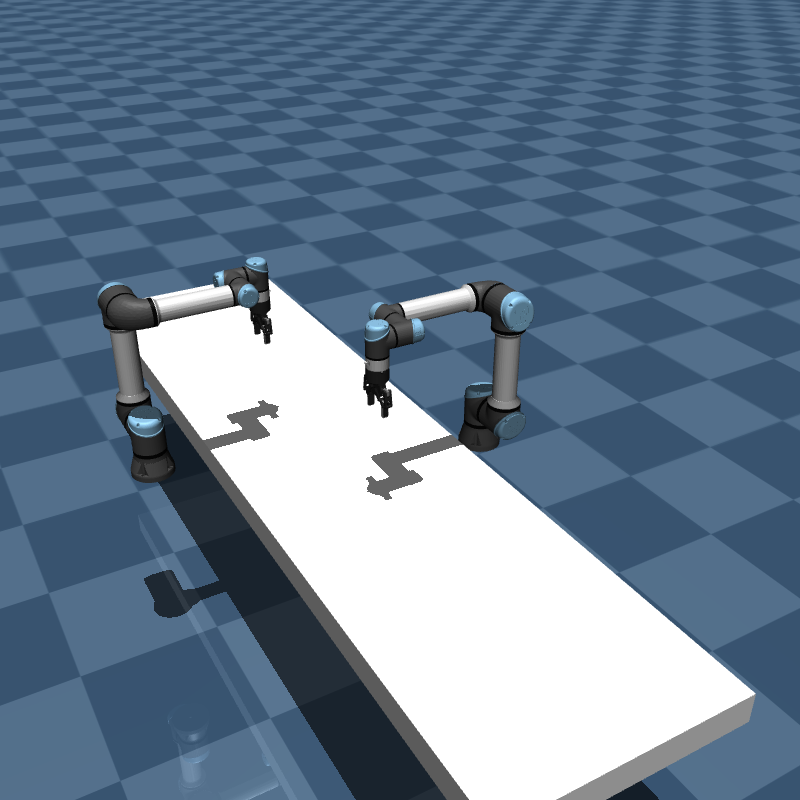

In [19]:
physics=mjcf.Physics.from_mjcf_model(sort_task)
physics.reset(0)
#final_physics=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/ur5e/ur5e_robotiq_full.xml')
pixels=physics.render(width=800,height=800,camera_id=5)

ctrl_shape=physics.data.ctrl.shape
PIL.Image.fromarray(pixels)
#print(physics.named.data.qpos)
#print(physics.data.qvel.shape)



In [20]:
%reload_ext autoreload
%autoreload 2
from dm_control import mujoco,viewer
from dm_control.mujoco.wrapper.core import MjvOption
from dm_control.mujoco.wrapper.mjbindings import enums
from rocobench import PlannedPathPolicy, LLMPathPlan, MultiArmRRT
from rocobench.envs import SimRobot
from rocobench import PlannedPathPolicy, LLMPathPlan, MultiArmRRT
from rocobench.envs.constants import PANDA_CONSTANTS
from rocobench.envs.constants import UR5E_ROBOTIQ_CONSTANTS
import copy
from rocobench.subtask_plan import LLMPathPlan
from rocobench.envs.env_utils import Pose



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [21]:
target_body='black_box'
target_body_top='box_top'
target_body_bottom='box_bottom'

def home_pose(physics,robots):
    # for key,value in robots.items:
    #     continue
    # qpos0=[0., 0., 0., -1.57079, 0, 1.57079, -0.7853,0]
    # ctrl0=[0, 0, 0, -1.57079, 0, 1.57079, -0.7853,0]
    # qpos=physics.data.qpos.copy()
    # qpos[panda1.joint_idxs_in_qpos]=np.array(qpos0)
    # qpos[ur5e.joint_idxs_in_qpos]=np.array(qpos0)
    # with physics.reset_context():
    #     physics.data.qpos=qpos
    #     physics.data.qvel=np.zeros_like(physics.data.qvel)
    #     physics.data.ctrl[panda1.joint_idxs_in_ctrl]=ctrl0
    #     physics.data.ctrl[panda2.joint_idxs_in_ctrl]=ctrl0
    #     physics.step()
    # return physics
    
    physics.reset(0)
    return physics

def append_panda_names(name,panda_constants):
    constants = dict()
    constants["name"] = name
    for key, value in panda_constants.items():
        #print(key)
        if (key=='name') :
            continue
        if key == "actuator_info":
            constants[key] = {name + "/" + x: name + "/" + y for x, y in value.items()}
        elif isinstance(panda_constants[key],str):
            constants[key]=name+'/'+value
        else:
            constants[key] = [name + "/" + x for x in value]

    return constants

def append_ur5e_names(name,ur5e_constants):
    constants = dict()
    constants["name"] = name
    for key, value in ur5e_constants.items():
        #print(key)
        if (key=='name') :
            continue
        if key == "actuator_info":
            constants[key] = {name + "/" + x: name + "/" + y for x, y in value.items()}
        elif isinstance(ur5e_constants[key],str):
            constants[key]=name+'/'+value
        else:
            constants[key] = [name + "/" + x for x in value]

    return constants

def append_robot_names(name, constants):
    result = dict()
    result["name"] = name
    for key, value in constants.items():
        #print(key)
        if key=='name':
            continue

        if key == "actuator_info":
            result[key] = {name + "/" + x: name + "/" + y for x, y in value.items()}
        elif key == "mesh_to_geoms":
            result[key] = {x: [name + "/" + y for y in z] for x, z in value.items()}

        elif isinstance(constants[key],str):
            result[key]= name+'/'+value
        else:
            result[key] = [name + "/" + x for x in value]

    return result

ur51_constants = append_panda_names("ur51",UR5E_ROBOTIQ_CONSTANTS)
ur52_constants = append_panda_names("ur52",UR5E_ROBOTIQ_CONSTANTS)

#ur5e=SimRobot(physics=physics,use_ee_rest_quat=False,**ur5e_constants)
panda1_constants = append_robot_names("panda1",PANDA_CONSTANTS)
panda2_constants = append_robot_names("panda2",PANDA_CONSTANTS)

ur51=SimRobot(physics=physics,use_ee_rest_quat=False,**ur51_constants)
ur52=SimRobot(physics=physics,use_ee_rest_quat=False,**ur52_constants)
robots={'ur51':ur51,'ur52':ur52}
#print(panda1.joint_idxs_in_ctrl)

In [61]:
physics.reset(0)
planner=MultiArmRRT(physics,robots,graspable_object_names=['black_box'])
#target_ee1=Pose(np.array([ 0.05453773, -0.20000233,  0.52447919]),np.array([ 0, 1, 0, 0]))
#target_ee2=Pose(np.array([ 1.05453773, -0.20000233,  0.52447919]),np.array([ 0, 1, 0, 0]))
def get_q(theta):
    theta=theta*np.pi/180
    return np.array([0,np.sin(theta/2),0,np.cos(theta/2)])
target_ee1=Pose(np.array([ -0.9, 0.5,  0.5]),get_q(00))
target_ee2=Pose(np.array([ +0.9, 0.5,  0.5]),get_q(00))
#target_ee
ee_poses={}
ee_poses['ur51']=target_ee1
ee_poses['ur52']=target_ee2
print(ee_poses)
result=planner.inverse_kinematics_all(physics,ee_poses)
print(result)
qpos=physics.data.qpos.copy()
qpos[result['ur51'][1]]=result['ur51'][0]
qpos[result['ur52'][1]]=result['ur52'][0]
print(qpos)
with physics.reset_context():
    physics.data.qpos=qpos
    physics.data.qvel=np.zeros_like(physics.data.qvel)
    physics.step()
    pixels=physics.render(width=800,height=800,camera_id=5)
PIL.Image.fromarray(pixels)
#planner.

{'ur51': Pose(pos=(-0.90,0.50,0.50),rot=(0.00,-0.00,3.14)), 'ur52': Pose(pos=(0.90,0.50,0.50),rot=(0.00,-0.00,3.14))}


{'ur51': None, 'ur52': None}


TypeError: 'NoneType' object is not subscriptable

In [22]:
import torch
import curobo
from curobo.types.math import Pose
from curobo.types.base import TensorDeviceType
from curobo.types.robot import JointState
from curobo.wrap.reacher.motion_gen import MotionGen, MotionGenConfig, MotionGenPlanConfig
from curobo.geom.sdf.world import CollisionCheckerType
from curobo.geom.types import WorldConfig, Cuboid, Mesh, Capsule, Cylinder, Sphere
from curobo.util_file import get_assets_path, join_path
from lxml import etree
from urdfpy import URDF,Link,Joint,Visual
import urdfpy
import numpy as np
from scipy.spatial.transform import Rotation
import yaml
import os
import copy
%reload_ext autoreload

In [63]:
#panda_assets_path='/home/vignesh/robot-collab_vig/rocobench/envs/assets/panda/assets'
#ur5_assets_path='/home/vignesh/robot-collab_vig/rocobench/envs/assets/ur5e_robotiq/ur5e_assets'
import os
from scipy.spatial.transform import Rotation as R
# def create_curobo_world(mjcf_object,physics,body_list,robot_body_name,world_config):
#     world_config={}
#     cuboid={}
#     sphere={}
#     mesh={}
#     capsule={}
#     cylinder={}
#     for body_name in body_list:
#         current_body=mjcf_object.find('body',body_name)
#         assert current_body!=None, "body name: "+body_name+'not found'
#         kid_geoms=current_body.find_all('geom')
#         for geom in kid_geoms:
#             geom_dict={}
#             if geom.type=='box':
#                 geom_dict['dims']=list(geom.size)
#                 geom_dict['pose']=list(transform_pose(physics.named.data.geom_xpos[geom.full_indentifier],physics.named.body.xpos[robot_body_name]))
#                 cuboid[geom.full_indentifier]=geom_dict
#             elif geom.type=='sphere':
#                 geom_dict['radius']=float(geom.size)
#                 geom_dict['pose']=list(transform_pose(physics.named.data.geom_xpos[geom.full_indentifier],physics.named.body.xpos[robot_body_name]))
#                 sphere[geom.full_indentifier]=geom_dict
#             elif geom.type=='capsule':
#                 geom_dict['radius']=float(geom.size[0])
#                 geom_dict['height']=2*float(geom.size[1])
#                 geom_dict['pose']=list(transform_pose(physics.named.data.geom_xpos[geom.full_indentifier],physics.named.body.xpos[robot_body_name]))
#                 capsule[geom.full_indentifier]=geom_dict
#             elif geom.type=='cylinder':
#                 geom_dict['radius']=float(geom.size[0])
#                 geom_dict['height']=2*float(geom.size[1])
#                 geom_dict['pose']=list(transform_pose(physics.named.data.geom_xpos[geom.full_indentifier],physics.named.body.xpos[robot_body_name]))
#                 cylinder[geom.full_indentifier]=geom_dict
#             elif geom.type=='mesh':
#                 geom_dict['file_path']=panda_assets_path
def transform_pose_robot(object_pose,robot_pose,verbose=False):
    robot_pose_x=robot_pose[0:3].copy()
    robot_pose_q=robot_pose[[4,5,6,3]].copy()
    object_pose_x=object_pose[0:3].copy()
    object_pose_q=object_pose[[4,5,6,3]].copy()
    robot_r=R.from_quat(robot_pose_q)
    object_r=R.from_quat(object_pose_q)
    new_pose_x=robot_r.inv().apply(object_pose_x-robot_pose_x)
    new_quat=robot_r.inv()*object_r
    if verbose:
        print(object_r.as_quat(),new_quat.as_quat())
    return np.concatenate((new_pose_x,-new_quat.as_quat()[[3,0,1,2]]))
def update_curobo_world(physics,world_config,robot_name):
    #print(world_config)
    robot_pos=np.concatenate((physics.named.data.xpos[robot_name],physics.named.data.xquat[robot_name]),axis=0)
    for object_type in world_config:
        object_dict=world_config[object_type]
        for name in object_dict:
            new_xpos=physics.data.xpos[physics.named.model.geom_bodyid[name]].copy()
            #new_xpos=-physics.named.data.geom_xpos[name]+physics.named.data.geom_pos[name]
            new_quat=physics.data.xquat[physics.named.model.geom_bodyid[name]]
            xpos_robot_frame=transform_pose_robot(np.concatenate((new_xpos,new_quat),axis=0).copy(),robot_pos.copy(),verbose=False)
            object_dict[name]['pose']=xpos_robot_frame.copy()
            
            #if name=='table_collision':
                #transform_pose_robot(np.concatenate((new_xpos,new_quat),axis=0),robot_pos,verbose=True)
#update_curobo_world(physics,world_config)

In [68]:

panda_assets_path = "robot/franka_description/meshes/collision"


#panda_constants = append_robot_names("panda", PANDA_CONSTANTS.copy())
#ur5e_constants = append_robot_names("ur5e", UR5E_ROBOTIQ_CONSTANTS.copy())
#panda_meshes = panda_constants["mesh_to_geoms"]
#ur5e_meshes = ur5e_constants["mesh_to_geoms"]
panda1_constants = append_robot_names("panda1",PANDA_CONSTANTS)
panda2_constants = append_robot_names("panda2",PANDA_CONSTANTS)
panda1_meshes=panda1_constants['mesh_to_geoms']
panda2_meshes=panda2_constants['mesh_to_geoms']
#print(panda1_meshes)
mesh_dict_panda1 = {}
mesh_dict_panda2= {}

#for key, v in panda_meshes.items():
#    mesh_dict[ panda_assets_path + '/' + key] = v

for key, v in panda2_meshes.items():
    mesh_dict_panda1[panda_assets_path + '/' + key] = v
for key, v in panda1_meshes.items():
    mesh_dict_panda2[panda_assets_path + '/' + key] = v

#print(mesh_dict['rocobench/assets/panda/assets/finger_0.obj'])

In [70]:
ur5e_assets_path = "robot/ur_description/meshes/ur5e/collision/"
ur51_constants = append_robot_names("ur51",UR5E_ROBOTIQ_CONSTANTS)
ur52_constants = append_robot_names("ur52",UR5E_ROBOTIQ_CONSTANTS)
ur51_meshes=ur51_constants['mesh_to_geoms']
ur52_meshes=ur52_constants['mesh_to_geoms']
#print(panda1_meshes)
mesh_dict_ur51 = {}
mesh_dict_ur52= {}

#for key, v in panda_meshes.items():
#    mesh_dict[ panda_assets_path + '/' + key] = v

for key, v in ur51_meshes.items():
    mesh_dict_ur51[ur5e_assets_path + '/' + key] = v
for key, v in ur52_meshes.items():
    mesh_dict_ur52[ur5e_assets_path + '/' + key] = v

In [85]:
mesh_dict_ur51

{'robot/ur_description/meshes/ur5e/collision//robotiq_assets/base_mount.stl': ['ur51/base_mount_collision'],
 'robot/ur_description/meshes/ur5e/collision//robotiq_assets/base.stl': ['ur51/base_collision'],
 'robot/ur_description/meshes/ur5e/collision//robotiq_assets/driver.stl': ['ur51/right_driver_collision',
  'ur51/left_driver_collision'],
 'robot/ur_description/meshes/ur5e/collision//robotiq_assets/coupler.stl': ['ur51/right_coupler_collision',
  'ur51/left_coupler_collision'],
 'robot/ur_description/meshes/ur5e/collision//robotiq_assets/spring_link.stl': ['ur51/right_spring_collision',
  'ur51/left_spring_collision'],
 'robot/ur_description/meshes/ur5e/collision//robotiq_assets/follower.stl': ['ur51/right_follower_collision',
  'ur51/left_follower_collision']}

In [87]:
def find_key_from_value(dictionary, value):
    for key, values in dictionary.items():
        if value in values:
            return key
    return None
def generate_world_config(physics, mesh_dict, geom_group = 3, mesh_test = False,robot_name=""):
    world_config = {"cylinder": {}, "cuboid": {}, "mesh": {}, "capsule": {}}
    
    collision_geom_idx = np.where(physics.model.geom_group == geom_group)[0]
    
    ### Looping over Robot Meshes for world_config ####
    for i in collision_geom_idx:
        
        # Access the geom model and data
        geom = physics.model.geom(i)
        geom_data = physics.data.geom(i)
        if(geom.name.split("/")[0] == robot_name):
            continue

        ## Check for different geom types ##
        if geom.type[0] ==  3: #Capsule       
            world_config["capsule"][geom.name] = { 
                                                    "radius": geom.size[0],
                                                    "base": [0,0,-geom.size[1]*2],
                                                    "tip": [0,0,geom.size[1]*2],
                                                    "pose" :np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                                }

        if geom.type[0] == 5: #Cylinder
            world_config["cylinder"][geom.name] = { 
                                                    "radius": geom.size[0],
                                                    "height": geom.size[1]*2,
                                                    "pose" : np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                                    }


        
        if geom.type[0] ==  6: #Cuboid
            #
            world_config["cuboid"][geom.name] = { 
                                                "dims": list(geom.size*2),
                                                "pose": np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                                }

        if geom.type[0] ==  7: #Mesh

            #Find the key for the mesh file
            #print(geom)
            mesh_file = find_key_from_value(mesh_dict, geom.name)

            world_config["mesh"][geom.name] = { 
                                               "file_path": mesh_file,
                                               "pose": np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                            }

    ### Testing Meshes Work ###
    if mesh_test:
        for key, value in world_config["mesh"].items():
            print(key, ":", value["file_path"])
    
    return world_config 

world_config_robot1 = generate_world_config(physics, mesh_dict_ur52, mesh_test = True,robot_name='ur51')
world_config_robot2 = generate_world_config(physics, mesh_dict_ur51, mesh_test = True,robot_name='ur52')

ur52/base_mount_collision : robot/ur_description/meshes/ur5e/collision//robotiq_assets/base_mount.stl
ur52/base_collision : robot/ur_description/meshes/ur5e/collision//robotiq_assets/base.stl
ur52/right_driver_collision : robot/ur_description/meshes/ur5e/collision//robotiq_assets/driver.stl
ur52/right_coupler_collision : robot/ur_description/meshes/ur5e/collision//robotiq_assets/coupler.stl
ur52/right_spring_collision : robot/ur_description/meshes/ur5e/collision//robotiq_assets/spring_link.stl
ur52/right_follower_collision : robot/ur_description/meshes/ur5e/collision//robotiq_assets/follower.stl
ur52/left_driver_collision : robot/ur_description/meshes/ur5e/collision//robotiq_assets/driver.stl
ur52/left_coupler_collision : robot/ur_description/meshes/ur5e/collision//robotiq_assets/coupler.stl
ur52/left_spring_collision : robot/ur_description/meshes/ur5e/collision//robotiq_assets/spring_link.stl
ur52/left_follower_collision : robot/ur_description/meshes/ur5e/collision//robotiq_assets/fol

In [94]:
world_config_robot1

{'cylinder': {'ur52/wrist3_collision': {'radius': 0.04,
   'height': 0.04,
   'pose': array([ 1.63399819e+00, -4.91998931e-01,  5.88000367e-01, -2.59735301e-06,
           5.55111512e-17,  7.07105483e-01, -7.07108080e-01])}},
 'cuboid': {'table_collision': {'dims': [3.2, 0.8, 0.1],
   'pose': array([ 0.75,  0.55, -0.01,  1.  , -0.  , -0.  , -0.  ])},
  'ur52/right_pad1': {'dims': [0.022, 0.008, 0.01875],
   'pose': array([ 1.68329741e+00, -4.91999894e-01,  3.75280186e-01, -4.77030129e-12,
           7.07108080e-01,  7.07105483e-01, -2.59734824e-06])},
  'ur52/right_pad2': {'dims': [0.022, 0.008, 0.01875],
   'pose': array([ 1.68329741e+00, -4.91999894e-01,  3.75280186e-01, -4.77030129e-12,
           7.07108080e-01,  7.07105483e-01, -2.59734824e-06])},
  'ur52/left_pad1': {'dims': [0.022, 0.008, 0.01875],
   'pose': array([ 1.58469741e+00, -4.91999531e-01,  3.75280548e-01,  2.59734824e-06,
           7.07105483e-01, -7.07108080e-01, -4.77030129e-12])},
  'ur52/left_pad2': {'dims': [0.0

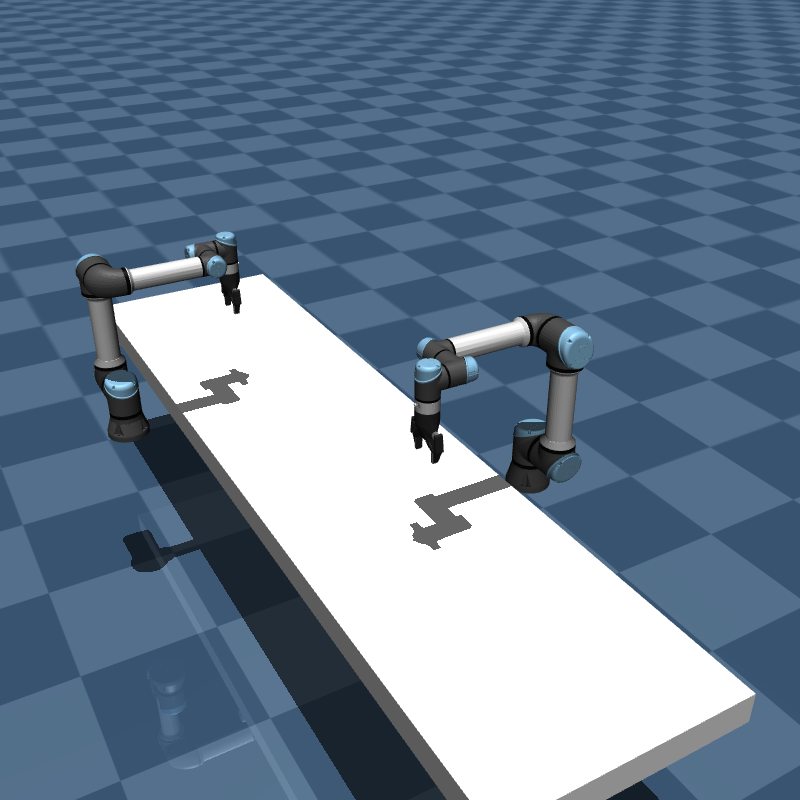

In [12]:
#physics=mjcf.Physics.from_mjcf_model(sort_task)

scene_option = MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = False
scene_option.flags[enums.mjtRndFlag.mjRND_SHADOW] = True # play with these values
# img = physics.render(
# camera_id='xxx', width=xxx, height=xxx,
# scene_option=scene_option), 
# render_flag_overrides={mujoco.mjtRndFlag.mjRND_REFLECTION: False}, # also play with these
# ) 
#physics.
physics.reset(0)
#final_physics=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/ur5e/ur5e_robotiq_full.xml')
pixels=physics.render(width=800,height=800,scene_option=scene_option,camera_id=5)

ctrl_shape=physics.data.ctrl.shape
PIL.Image.fromarray(pixels)
#np.concatenate((physics.named.data.xpos['ur5e/'],physics.named.data.xquat['ur5e/']),axis=0)

In [96]:
physics.reset(0)
update_curobo_world(physics,world_config_robot1,'ur51/')
update_curobo_world(physics,world_config_robot2,'ur52/')
#world_config_panda2
#world_config['cuboid']={'empty':{'pose':[0,0,0.2],'dims':[0.1,0.1,0.1]}}

In [92]:
physics.named.data.qpos

FieldIndexer(qpos):
 0          ur51/ur5e_0_base_joint [ 0.000149]
 1  ur51/ur5e_0_shoulder_pan_joint [ 0.94    ]
 2 ur51/ur5e_0_shoulder_lift_joint [-1.49    ]
 3         ur51/ur5e_0_elbow_joint [ 1.47    ]
 4       ur51/ur5e_0_wrist_1_joint [-1.54    ]
 5       ur51/ur5e_0_wrist_2_joint [-1.57    ]
 6       ur51/ur5e_0_wrist_3_joint [-0.631   ]
 7         ur51/right_driver_joint [ 0.00292 ]
 8        ur51/right_coupler_joint [ 0.0027  ]
 9    ur51/right_spring_link_joint [ 0.00718 ]
10       ur51/right_follower_joint [-0.0128  ]
11          ur51/left_driver_joint [ 0.00292 ]
12         ur51/left_coupler_joint [ 0.0027  ]
13     ur51/left_spring_link_joint [ 0.00717 ]
14        ur51/left_follower_joint [-0.0128  ]
15          ur52/ur5e_0_base_joint [-0.00107 ]
16  ur52/ur5e_0_shoulder_pan_joint [ 1.56    ]
17 ur52/ur5e_0_shoulder_lift_joint [-0.976   ]
18         ur52/ur5e_0_elbow_joint [ 1.87    ]
19       ur52/ur5e_0_wrist_1_joint [-1.17    ]
20       ur52/ur5e_0_wrist_2_joint [-1.5

In [43]:
def clean_robot(urdf_object,append_string="_1"):
    for link in urdf_object.links:
        link.name=link.name+append_string
    for joint in urdf_object.joints:
        joint.name=joint.name+append_string
        joint.parent=joint.parent+append_string
        joint.child=joint.child+append_string
    return urdf_object
def pose_list_to_pose_matrix(pose):
    pose_matrix=np.eye(4)
    rot=Rotation.from_quat(np.array(pose)[[4,5,6,3]])
    
    pose_matrix[0:3,3]=pose[0:3]
    pose_matrix[0:3,0:3]=rot.as_matrix()
    return pose_matrix
def add_robots_urdf(urdf_list,pose_list,name):
    assert len(urdf_list)==len(pose_list),'inputs should be of same length'
    base_link=Link('base_fixture_link',None,visuals=[Visual(urdfpy.Geometry(sphere=urdfpy.Sphere(0.1)))],collisions=None)
    new_links=[base_link]
    new_joints=[]
    for i in range(len(urdf_list)):
        robot_pose=pose_list[i]
        urdf_list[i]=clean_robot(urdf_list[i],"_"+str(i+1))
        new_links+=urdf_list[i].links
        new_joints+=[Joint(name=base_link.name+"_j_"+urdf_list[i].base_link.name,joint_type='fixed',parent=base_link.name,child=urdf_list[i].base_link.name,origin=list(pose_list_to_pose_matrix(robot_pose)))]
        new_joints+=urdf_list[i].joints
    #for links in new_links:
        #print(link.name)
    #kinematics={}
    return URDF(name,links=new_links,joints=new_joints)
def combine_yaml_kinematics(config_list,combined_urdf_path,config_path):
    kinematic_list=[]
    for config in config_list:
        kinematic_list.append(config['robot_cfg']['kinematics'])
    new_kinematics={'urdf_path':combined_urdf_path,'asset_root_path':'/robot','base_link':'base_fixture_link'}
    #new_lock_joints={}
    collison_sphere={} #
    ee_link=kinematic_list[0]['ee_link']+"_1"
    links_names=[]#
    lock_joints={}#
    extra_links={}#
    collison_sphere_buffer=0.0#
    extra_collison_spheres={}#
    self_collison_ignore={}#
    self_collison_buffer={}#
    mesh_link_names=[]#
    collision_link_names=[]#
    use_global_cumul=False#
    cspace={'joint_names':[],'retract_config':[],'null_space_weight':[],'cspace_distance_weight':[],'max_jerk':float('inf'),'max_acceleration':float('inf')}
    for i in range(len(kinematic_list)):
        if isinstance(kinematic_list[i]['collision_spheres'],str):
            with open(os.path.join(config_path,'spheres'), 'r') as f:
                spheres_i = yaml.load(f, Loader=yaml.SafeLoader)['collision_spheres']
                
        else:
            spheres_i=kinematic_list[i]['collision_spheres']
        spheres_i={key+"_"+str(i+1):value for key,value in spheres_i.items()}
        collison_sphere.update(spheres_i)
        links_names.append(kinematic_list[i]['ee_link']+'_'+str(i+1))
        if kinematic_list[i]['lock_joints'] is not None:
            lock_joints.update({key+"_"+str(i+1):value for key,value in kinematic_list[i]['collision_spheres'].items()})
        if kinematic_list[i]['extra_links'] is not None:
            for k,v in kinematic_list[i]['extra_links'].items():
                v['parent_link_name']+="_"+str(i+1)
                v['link_name']+="_"+str(i+1)
                v['joint_name']+="_"+str(i+1)
                extra_links[k+"_"+str(i+1)]=v
        collison_sphere_buffer=max(collison_sphere_buffer,kinematic_list[i]['collision_sphere_buffer'])
        if kinematic_list[i]['extra_collision_spheres'] is not None:
            extra_collison_spheres.update({key+"_"+str(i+1):value for key,value in kinematic_list[i]['extra_collision_spheres'].items()})
        self_collison_ignore.update({key+"_"+str(i+1):[vi+"_"+str(i+1) for vi in value] for key,value in kinematic_list[i]['self_collision_ignore'].items()})
        self_collison_buffer.update({key+"_"+str(i+1):value for key,value in kinematic_list[i]['self_collision_buffer'].items()})
        mesh_link_names+=[name+"_"+str(i+1) for name in kinematic_list[i]['mesh_link_names']]
        collision_link_names+=[name+"_"+str(i+1) for name in kinematic_list[i]['collision_link_names']]
        use_global_cumul=(use_global_cumul or kinematic_list[i]['use_global_cumul'])
        cspace['joint_names']+=[name+"_"+str(i+1) for name in kinematic_list[i]['cspace']['joint_names']]
        cspace['retract_config']+=kinematic_list[i]['cspace']['retract_config']
        cspace['null_space_weight']+=kinematic_list[i]['cspace']['null_space_weight']
        cspace['cspace_distance_weight']+=  kinematic_list[i]['cspace']['cspace_distance_weight']
        cspace['max_jerk']=min(cspace['max_jerk'],kinematic_list[i]['cspace']['max_jerk'])
        cspace['max_acceleration']=min(cspace['max_acceleration'],kinematic_list[i]['cspace']['max_acceleration'])
    new_kinematics['collision_spheres']=collison_sphere
    new_kinematics['ee_link']=ee_link
    new_kinematics['link_names']=links_names
    new_kinematics['lock_joints']=lock_joints
    new_kinematics['extra_links']=extra_links
    new_kinematics['collision_sphere_buffer']=collison_sphere_buffer
    new_kinematics['extra_collision_spheres']=extra_collison_spheres
    new_kinematics['self_collision_ignore']=self_collison_ignore
    new_kinematics['self_collision_buffer']=self_collison_buffer
    new_kinematics['mesh_link_names']=mesh_link_names
    new_kinematics['collision_link_names']=collision_link_names
    new_kinematics['use_global_cumul']=use_global_cumul
    new_kinematics['cspace']=cspace
    return {'robot_cfg':{'kinematics':new_kinematics}}

In [44]:
robot_list=[URDF.load('/home/vignesh/curobo/src/curobo/content/assets/robot/ur_description/ur5e_new.urdf'),URDF.load('/home/vignesh/curobo/src/curobo/content/assets/robot/ur_description/ur5e_new.urdf')]
pose_list=[[-0.2,-0.55,0.1,1,0,0,0],[0.2,0.55,0.1,0,0,0, 1]]
final=add_robots_urdf(robot_list,pose_list,name='dual_ur5e_new')
#final.show()
final.save('/home/vignesh/curobo/src/curobo/content/assets/robot/ur_description/dual_ur5e_new.urdf')

In [45]:
with open('/home/vignesh/curobo/src/curobo/content/configs/robot/ur5e_new.yml', 'r') as f:
    ur5e_config = yaml.load(f, Loader=yaml.SafeLoader)
ur5e_config.keys()
ur51_config=copy.deepcopy(ur5e_config)
ur52_config=copy.deepcopy(ur5e_config)
new_yaml=combine_yaml_kinematics([ur51_config,ur52_config],'robot/ur_description/dual_ur5e_new.urdf','~/curobo/src/curobo/content/configs/robot')
with open('/home/vignesh/curobo/src/curobo/content/configs/robot/dual_ur5e_new.yml', 'w') as outfile:
    yaml.dump(new_yaml, outfile, default_flow_style=False)

In [46]:

motion_gen_config_1=MotionGenConfig.load_from_robot_config("dual_ur5e_new.yml",{'cuboid':{'table_collision': {'dims': [3.2, 0.8, 0.1],
   'pose': np.array([-0.0,  0.0, -0.0,  1.  , -0.  , -0.  , -0.  ])}}},interpolation_dt=0.05,
    collision_checker_type=CollisionCheckerType.MESH,collision_activation_distance=0.05,trajopt_dt=0.25)
motion_gen1 = MotionGen(motion_gen_config_1)
motion_gen1.warmup(parallel_finetune=True)

In [51]:
physics.reset(0)
start_state = JointState.from_position(
    torch.tensor(physics.data.qpos[[1,2,3,4,5,6,16,17,18,19,20,21]],dtype=torch.float32).view(1,-1).cuda())
goal_pose = Pose.from_list([0.2, 0., 0.5, 0.0, 1.0, 0.0, 0.0],q_xyzw=False,tensor_args=TensorDeviceType(dtype=torch.float32))
target_links={'tool_2':Pose.from_list([-0.2, 0., 0.5, 0.0, 1.0, 0.0, 0.0],q_xyzw=False,tensor_args=TensorDeviceType(dtype=torch.float32))}
result = motion_gen1.plan_single(start_state, goal_pose, MotionGenPlanConfig(max_attempts=10,time_dilation_factor=0.5,),target_links)
traj = result.get_interpolated_plan()  # result.optimized_dt has the dt between timesteps
print("Trajectory Generated: ", result.success)

Trajectory Generated:  tensor([True], device='cuda:0')


In [52]:
traj.position.shape

torch.Size([62, 12])

In [110]:
physics.reset(0)
update_curobo_world(physics,world_config_robot1,'ur51/')
world_model_class_1=WorldConfig.from_dict(world_config_robot1)
world_model_class_1=WorldConfig.create_obb_world(world_model_class_1)
motion_gen_config_1 = MotionGenConfig.load_from_robot_config(
    "dual_ur5e.yml",
    {'cuboid':{'table_collision': {'dims': [3.2, 0.8, 0.1],
   'pose': np.array([-0.0,  0.55, -0.01,  1.  , -0.  , -0.  , -0.  ])}}},
    interpolation_dt=0.05,
    collision_checker_type=CollisionCheckerType.PRIMITIVE,collision_activation_distance=0.025,trajopt_dt=0.25,
)
motion_gen1 = MotionGen(motion_gen_config_1)
motion_gen1.warmup(parallel_finetune=True)
#retract_cfg = motion_gen.get_retract_config()
print("warm")
#update_curobo_world(physics,world_config_panda1,'panda1/')
#torch.cuda.empty_cache()
#state = motion_gen.rollout_fn.compute_kinematics(
#    JointState.from_position(retract_cfg.view(1, -1))
#)
#physics.reset()


warm


In [148]:
physics.reset(0)
#update_curobo_world(physics,world_config_panda1,'panda1/')
#world_model_class_1=WorldConfig.from_dict(world_config_panda1)
#world_model_class_1=WorldConfig.create_obb_world(world_model_class_1)
link_names = motion_gen1.kinematics.link_names
ee_link_name = motion_gen1.kinematics.ee_link
target_links={'tool1':Pose.from_list([-0.8, 0.5, 0.5, 0.0, 1.0, 0.0, 0.0],q_xyzw=False,tensor_args=TensorDeviceType(dtype=torch.float32))}
#motion_gen1.update_world(world_model_class_1)
goal_pose = Pose.from_list([0.75, 0.5, 0.5, 0.0, 1.0, 0.0, 0.0],q_xyzw=False,tensor_args=TensorDeviceType(dtype=torch.float32))  # x, y, z, qw, qx, qy, qz
start_state = JointState.from_position(
    torch.tensor(physics.data.qpos[[1,2,3,4,5,6,16,17,18,19,20,21]],dtype=torch.float32).view(1,-1).cuda(),
    #joint_names=[
        #"shoulder_pan_joint",
        #"shoulder_lift_joint",
        #"elbow_joint",
        #"wrist_1_joint",
        #"wrist_2_joint",
        #"wrist_3_joint",
    #],
)

#result = motion_gen1.plan_single(start_state, goal_pose, MotionGenPlanConfig(max_attempts=5,parallel_finetune=True,enable_graph=True,enable_opt=True,time_dilation_factor=0.5,finetune_attempts=1))
result = motion_gen1.plan_single(start_state, goal_pose, MotionGenPlanConfig(max_attempts=10,time_dilation_factor=0.5),link_poses=target_links)
traj = result.get_interpolated_plan()  # result.optimized_dt has the dt between timesteps
print("Trajectory Generated: ", result.success)

Trajectory Generated:  tensor([True], device='cuda:0')


In [58]:
physics.reset(0)
physics.named.data.ctrl

FieldIndexer(ctrl):
 0             panda1/panda_base [-0.346   ]
 1              panda1/actuator1 [ 0.634   ]
 2              panda1/actuator2 [ 0.362   ]
 3              panda1/actuator3 [ 0.43    ]
 4              panda1/actuator4 [-1.7     ]
 5              panda1/actuator5 [-0.165   ]
 6              panda1/actuator6 [ 2.02    ]
 7              panda1/actuator7 [ 1.9     ]
 8 panda1/panda_gripper_actuator [ 255     ]
 9             panda2/panda_base [-0.415   ]
10              panda2/actuator1 [ 0.597   ]
11              panda2/actuator2 [ 0.32    ]
12              panda2/actuator3 [ 0.507   ]
13              panda2/actuator4 [-1.77    ]
14              panda2/actuator5 [-0.172   ]
15              panda2/actuator6 [ 2.05    ]
16              panda2/actuator7 [-1.19    ]
17 panda2/panda_gripper_actuator [ 255     ]

In [53]:
frames = []
ctrls=[]
duration=4
framerate=20
control_rate=0.05
physics.reset(0)  # Reset state and time
#physics=home_pose(physics,robots)
#physics.model.eq_active[0:4]=0
#physics.model.eq_active[4:8]=1

#print(physics.named.model.eq_active)
#physics.model.eq_active[0:4]=0
action_id=0
eq_ids=[0]
#current_panda=panda1
t_initial=physics.data.time
while (physics.data.time-t_initial) < duration:
# for path in paths:
    idx = int((physics.data.time-t_initial)/ control_rate)
    # if idx>=eq_ids[action_id]:
    #     print(action_id)
        
    #     physics.model.eq_active[actions[action_id][0]]=actions[action_id][1]
    #     #print(physics.data.time,physics.named.model.eq_active)
    #     action_id=min(action_id+1,len(eq_ids)-1)
    if idx >= len(traj.position.cpu().numpy()):
        idx = len(traj.position.cpu().numpy()) - 1
    
    # with physics.reset_context():
    t0=physics.data.time
    qpos_full=physics.data.qpos.copy()
    #print(qpos_full.shape)
    #qpos_full[panda1.joint_idxs_in_qpos]=paths_list[idx][0:8]
    qpos_full[1:7]=list(traj.position[idx,0:6].cpu())
    qpos_full[16:22]=list(traj.position[idx,6:12].cpu())
    #p1_full_state_qpos = [paths[idx][i] for i in range(7)] + [0. for i in range(7, 18)]
    #panda1_ctrl = panda1.map_qpos_to_joint_ctrl(np.array(qpos_full))

    #p2_full_state_qpos = [0. for i in range(9)] + [paths[idx][i] for i in range(7, 14)] 
    ur51_ctrl = ur51.map_qpos_to_joint_ctrl(qpos_full)
    ur52_ctrl = ur52.map_qpos_to_joint_ctrl(qpos_full)
    ctrl=physics.data.ctrl.copy()
    #ctrl[panda1_ctrl['ctrl_idxs']]=panda1_ctrl['ctrl_vals']
    #ctrl[panda1.grasp_idx_in_ctrl]=255
    ctrl[ur51_ctrl['ctrl_idxs']]=ur51_ctrl['ctrl_vals']
    ctrl[ur52_ctrl['ctrl_idxs']]=ur52_ctrl['ctrl_vals']
    #ctrl[current_panda.grasp_idx_in_ctrl]=255
    #print(ctrl)
    #break
    #ctrl=np.concatenate((panda1_ctrl['ctrl_vals'],[255],panda2_ctrl['ctrl_vals'],[255]))
    physics.data.ctrl=ctrl
    while physics.data.time-t0<control_rate:

        physics.step()
        if len(frames) < physics.data.time * framerate:
            pixels = physics.render(width=1000,height=1000,camera_id=5)
            frames.append(pixels)
print("Rendering")
display_video(frames, framerate)

Rendering
